### Creation of bikeshares <> weather dataframe(data/result_parquet)

In [18]:
%run utilities.ipynb

In [19]:
spark = spark_session()

In [20]:
bikeshareDf = spark.read.csv('./data/sample.csv', header=True)

In [21]:
transformed_bikeshareDf = parse_date(bikeshareDf)

In [22]:
final_bikeshareDf = transformed_bikeshareDf\
    .withColumnRenamed('start station name', 'start_station_name')\
    .withColumnRenamed('end station name',  'end_station_name')\
    .withColumnRenamed('birth year', 'birth_year')



In [23]:
weatherDf = spark.read.csv('./data/weather_data_nyc_2016.csv', header=True)

weatherDf = weatherDf.withColumnRenamed('maximum temperature', 'maximum_temperature')\
                    .withColumnRenamed( 'minimum temperature', 'minimum_temperature')\
                    .withColumnRenamed('average temperature', 'average_temperature')\
                    .withColumnRenamed('snow fall', 'snow_fall')\
                    .withColumnRenamed('snow depth', 'snow_depth')


In [24]:
bikeshares_wheaterDf = final_bikeshareDf.join(weatherDf, final_bikeshareDf['date_for_join'] == weatherDf['date'], 'inner')

In [25]:
bikeshares_wheaterDf_final = bikeshares_wheaterDf.select( 'tripduration', 
                                                        'start_station_name', 
                                                        'end_station_name',
                                                        'usertype',
                                                        'birth_year',
                                                        'gender',
                                                        'date',
                                                        'maximum_temperature',
                                                        'minimum_temperature',
                                                        'average_temperature',
                                                        'precipitation',
                                                        'snow_fall',
                                                        'snow_depth')

In [26]:
handle_df_columns(bikeshares_wheaterDf, final_bikeshareDf)

OK!


In [27]:
bikeshares_wheaterDf_final.write.mode('overwrite').csv('./data/result_csv')

In [28]:
bikeshare_wheater_analyticsDf = spark.read.csv('./data/result_csv', schema=schema, header=True)

In [29]:
bikeshare_wheater_analyticsDf = preanalytics_filter(bikeshare_wheater_analyticsDf)

In [30]:
bikeshare_wheater_analyticsDf.write.mode('overwrite').parquet('./data/result_parquet')

### Start from here if `starter.sh` is executed or data/result_parquet is present

In [31]:
analyticsDf = spark.read.parquet('./data/result_parquet')

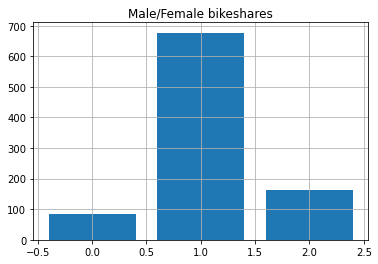

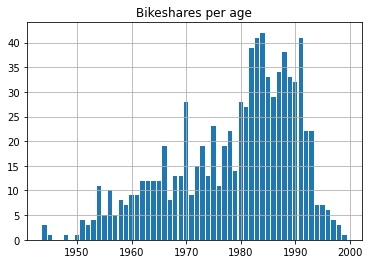

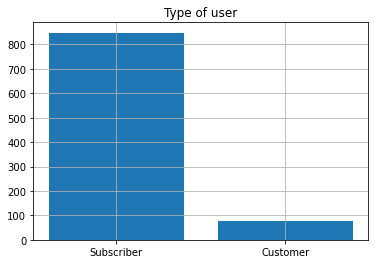

In [32]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from collections import Counter

'''
 0 --> unknown
 1 --> male
 2 --> female
'''

def prepare_for_bar(column, title):
    xpoint = analyticsDf.select(f.collect_list(column)).first()[0]
    x = Counter(xpoint).keys()
    y = Counter(xpoint).values()

    
    plt.title(title)
    plt.grid()
    plt.bar(x, y)
    plt.show()
   
prepare_for_bar('gender', 'Male/Female bikeshares')

prepare_for_bar('birthyear', 'Bikeshares per age')

prepare_for_bar('user_type', 'Type of user')


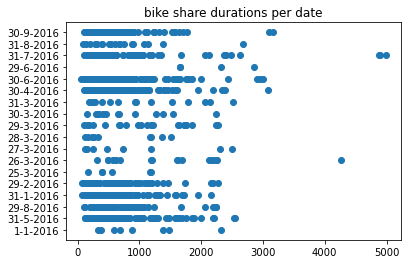

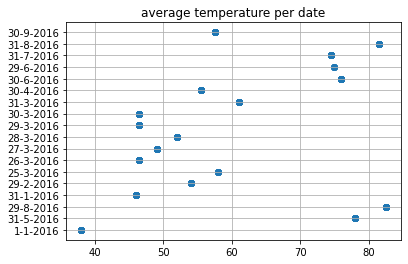

In [33]:

avg_temp = analyticsDf.select(f.collect_list('average_temperature')).first()[0]
tripdur = analyticsDf.select(f.collect_list('tripduration')).first()[0]
date = analyticsDf.select(f.collect_list('date')).first()[0]

plt.title('bike share durations per date')
plt.scatter(tripdur, date)

plt.show()
plt.title('average temperature per date')
plt.grid()
plt.scatter(avg_temp,date) 
plt.show()



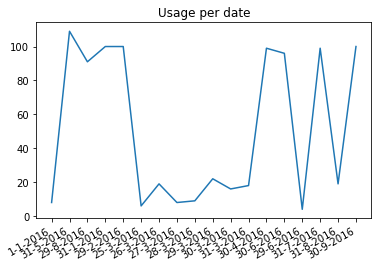

In [34]:
xpoint = analyticsDf.select(f.collect_list('date')).first()[0]
x = Counter(xpoint).keys()
y = Counter(xpoint).values()
fig, ax = plt.subplots()
ax.plot_date(x, y, marker='', linestyle='-')
fig.autofmt_xdate()
plt.title('Usage per date')
plt.show()
